# Highway classifier - Gabbar

## Step 1. Prepare problem

#### 1a. Load libraries

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('ticks')

In [3]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve

In [4]:
pd.set_option('display.precision', 2)
pd.set_option('display.max_columns', None)

In [5]:
random_state = 5
cv = 10

In [6]:
non_training_attributes = [
    'changeset_id', 'changeset_harmful', 'feature_id',
#     'feature_version',
#     'action_create', 'action_modify', 'action_delete',
#     'geometry_type_node', 'geometry_type_way', 'geometry_type_relation',
#     'geometry_line_distance', 'geometry_kinks', 
#     'old_user_mapping_days', 'new_user_mapping_days',
    'new_tags', 'old_tags'
]

## Labelled dataset

In [7]:
labelled_path = '../downloads/highway-classifier/labelled/'

In [8]:
labelled = pd.read_csv(labelled_path + 'attributes.csv')
print(labelled.shape)

# Sort the dataset randomly.
labelled = labelled.sample(labelled.shape[0], random_state=random_state)
labelled.head()

(2272, 29)


,changeset_id,changeset_harmful,feature_id,feature_version,action_create,action_modify,action_delete,geometry_type_node,geometry_type_way,geometry_type_relation,geometry_distance_between_versions,old_geometry_line_distance,old_geometry_number_of_nodes,old_geometry_kinks,old_geometry_area,new_geometry_line_distance,new_geometry_number_of_nodes,new_geometry_kinks,new_geometry_area,old_user_mapping_days,new_user_mapping_days,difference_user_mapping_days,ratio_user_mapping_days,old_number_of_tags,new_number_of_tags,difference_number_of_tags,ratio_number_of_tags,old_tags,new_tags
1503,47332261,0,22753759,5,0,1,0,0,1,0,0.0,0.11,5,0,0.0,0.11,5,0,0.0,2813,1,-2812,3.55e-04,4,5,1,1.25,NaN,{surface=asphalt}
2162,46038962,0,4072253881,2,0,1,0,1,0,0,0.0,0.00,2,0,0.0,0.00,2,0,0.0,98,76,-22,7.76e-01,0,2,2,0.00,NaN,{highway=motorway_junction} {noref=yes}
544,47538955,0,39383065,4,0,1,0,0,1,0,0.0,0.04,3,0,0.0,0.04,3,0,0.0,2611,148,-2463,5.67e-02,3,4,1,1.33,NaN,{surface=asphalt}
1002,47455929,0,22944171,25,0,1,0,0,1,0,0.0,0.98,18,0,0.0,0.98,18,0,0.0,22,1,-21,4.55e-02,3,4,1,1.33,NaN,{surface=asphalt}
1022,47451595,0,173303722,3,0,1,0,0,1,0,0.0,0.19,3,0,0.0,0.19,3,0,0.0,2813,1498,-1315,5.33e-01,4,5,1,1.25,NaN,{surface=asphalt}


In [9]:
# Drop all duplicate samples.
print('Shape before dropping duplicates: {}'.format(labelled.shape))
labelled = labelled.drop_duplicates(subset=['changeset_id', 'feature_id'])
print('Shape after dropping duplicates: {}'.format(labelled.shape))

Shape before dropping duplicates: (2272, 29)
Shape after dropping duplicates: (2272, 29)


In [10]:
# Fill null values in tags with empty string.
labelled['old_tags'] = labelled['old_tags'].fillna('')
labelled['new_tags'] = labelled['new_tags'].fillna('')

In [11]:
# Distribution of good and harmful changesets?
labelled.groupby('changeset_harmful').size()

changeset_harmful
0    2217
1      55
dtype: int64

In [12]:
total = labelled.shape[0]

# 60% of the dataset will be used for training.
training = labelled.iloc[0:round(0.6 * total)]
training = training.reset_index(drop=True)
print('Training: {}'.format(training.shape))

# 40% of the dataset will be used for validation.
validation = labelled.iloc[round(0.6 * total):]
validation = validation.reset_index(drop=True)
print('Validation: {}'.format(validation.shape))

Training: (1363, 29)
Validation: (909, 29)


#### new_tags

In [13]:
from sklearn.feature_extraction.text import CountVectorizer
new_vectorizer = CountVectorizer(
    analyzer='word',
    tokenizer=None,
    lowercase=False,
    token_pattern=r'\{([^=]+=[^=]+)\}',
)

# NOTE: Training vectorizer only on harmful changesets.
new_vectorizer.fit(training['new_tags'])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=False, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='\\{([^=]+=[^=]+)\\}',
        tokenizer=None, vocabulary=None)

In [14]:
# Looking at some feature names.
print('Number of vectors in new: {}'.format(len(new_vectorizer.get_feature_names())))
new_vectorizer.get_feature_names()

Number of vectors in new: 235


['access:conditional=yes @(08:00-20:00)',
 'access=destination',
 'access=no',
 'access=permissive',
 'access=private',
 'access=yes',
 'access=yes|yes|no',
 'access_control=yes',
 'amenity=school',
 'area=yes',
 'barrier=gate',
 'barrier=yes',
 'bench=no',
 'bench=yes',
 'bicycle=designated',
 'bicycle=discouraged',
 'bicycle=dismount',
 'bicycle=no',
 'bicycle=permissive',
 'bicycle=yes',
 'bridge=yes',
 'bus=yes',
 'bus_routes=411A;416;417A;410',
 'button_operated=no',
 'construction=motorway',
 'construction=tertiary',
 'construction=unclassified',
 'crossing=no',
 'crossing=traffic_signals',
 'crossing=uncontrolled',
 'crossing=zebra',
 'cycleway:left=lane',
 'cycleway:left=opposite_lane',
 'cycleway:right=lane',
 'cycleway:right=shared_lane',
 'cycleway=lane',
 'cycleway=opposite',
 'cycleway=opposite_lane',
 'cycleway=shared_lane',
 'designation=byway_open_to_all_traffic',
 'destination:ref=A20',
 'destination:ref=I-10 East;I-10 West',
 'destination=Maidstone (E)',
 'direction=b

In [15]:
# Convert to a Pandas DataFrame to make merging easier.
new_vectorized = pd.DataFrame(
    new_vectorizer.transform(training['new_tags']).toarray(),
    columns=new_vectorizer.get_feature_names()
)

# Add "new" prefix to column names.
new_vectorized.columns = ['new_{}'.format(item) for item in new_vectorized.columns]
new_vectorized.head()

,new_access:conditional=yes @(08:00-20:00),new_access=destination,new_access=no,new_access=permissive,new_access=private,new_access=yes,new_access=yes|yes|no,new_access_control=yes,new_amenity=school,new_area=yes,new_barrier=gate,new_barrier=yes,new_bench=no,new_bench=yes,new_bicycle=designated,new_bicycle=discouraged,new_bicycle=dismount,new_bicycle=no,new_bicycle=permissive,new_bicycle=yes,new_bridge=yes,new_bus=yes,new_bus_routes=411A;416;417A;410,new_button_operated=no,new_construction=motorway,new_construction=tertiary,new_construction=unclassified,new_crossing=no,new_crossing=traffic_signals,new_crossing=uncontrolled,new_crossing=zebra,new_cycleway:left=lane,new_cycleway:left=opposite_lane,new_cycleway:right=lane,new_cycleway:right=shared_lane,new_cycleway=lane,new_cycleway=opposite,new_cycleway=opposite_lane,new_cycleway=shared_lane,new_designation=byway_open_to_all_traffic,new_destination:ref=A20,new_destination:ref=I-10 East;I-10 West,new_destination=Maidstone (E),new_direction=both,"new_fixme=en attente d'areté municipal (probablement bande cyc lable) si cela se transforme en piste, ontraçera les deux pistes monodirectionnelles",new_fixme=turn:lanes:forward - double check not visible from imagery,new_foot=designated,new_foot=no,new_foot=permissive,new_foot=yes,new_footway=crossing,new_footway=sidewalk,new_handrail=yes,new_hgv=no,new_highway=bridleway,new_highway=bus_stop,new_highway=construction,new_highway=crossing,new_highway=cycleway,new_highway=footway,new_highway=living_street,new_highway=mini_roundabout,new_highway=motorway,new_highway=motorway_junction,new_highway=motorway_link,new_highway=path,new_highway=pedestrian,new_highway=primary,new_highway=primary_link,new_highway=raceway,new_highway=residential,new_highway=road,new_highway=secondary,new_highway=secondary_link,new_highway=service,new_highway=steps,new_highway=tertiary,new_highway=tertiary_link,new_highway=track,new_highway=traffic_signals,new_highway=trunk,new_highway=turning_circle,new_highway=unclassified,new_historic=construction,new_horse=no,new_horse=permissive,new_horse=yes,new_incline=up,new_junction=roundabout,new_landuse=cemetery,new_landuse=footway,new_landuse=forest,new_landuse=grass,new_landuse=recreation_ground,new_landuse=residential,new_landuse_1=park,new_landuse_1=recreation_ground,new_landuse_2=festival area,new_landuse_3=dog park,new_landuse_3=recreation,new_landuse_4=recreation_ground,new_landuse_5=water_park,new_lanes:forward=1,new_lanes=1,new_lanes=2,new_lanes=3,new_lanes=4,new_layer=-1,new_layer=1,new_layer=3,new_lcn=yes,new_leisure=park,new_leisure=playground,new_level=-1;0;1;1.75;2.25,new_lit=no,new_lit=yes,new_mapillary=0lY-vDeFoNZG6v_xeCwwzA,new_maxheight=3.2,new_maxspeed:hgv=60 mph,new_maxspeed=100,new_maxspeed=20 mph,new_maxspeed=25 mph,new_maxspeed=30,new_maxspeed=35 mph,new_maxspeed=40,new_maxspeed=40 mph,new_maxspeed=45 mph,new_maxspeed=50,new_maxspeed=50|30,new_maxspeed=60,new_maxspeed=60 mph,new_maxspeed=70,new_maxspeed=70 mph,new_maxspeed=8,new_maxspeed=90,new_maxwidth=2.2,new_motor_vehicle:conditional=no @ (Mo-Fr 06:00-08:30),new_motor_vehicle:conditional=no @ (Mo-Sa 20:00-08:00;Su 00:00-24:00),new_motor_vehicle=destination,new_motor_vehicle=no,new_motor_vehicle=permissive,new_motor_vehicle=private,new_motor_vehicle=yes,new_mtb:scale:imba=0,new_mtb:scale:imba=2,new_mtb:scale=0,new_mtb:scale=1,new_natural=footway,new_natural=residential,new_network=WMATA,new_noname=yes,new_noref=yes,new_oneway:bicycle=no,new_oneway:bicycle=yes,new_oneway:psv=no,new_oneway=no,new_oneway=yes,new_oneway=�,"new_operator=Carris 201, 748, 751 Vimeca 10",new_operator=Phébus,new_postal_code=20005,new_proposed=traffic_signals,new_psv=no|no|yes,new_psv=official,new_public_transport=platform,new_rcn=yes,new_ref=20,"new_ref=52,53,54",new_ref=BW 74,new_ref=US 29;VA 237,new_ref=http://www.mitchamcouncil.sa.gov.au/webdata/resources/files/Zone%202%20Map%202016.pdf,new_route=ferry,new_sac_scale=hiking,new_safety_rope=yes,new_segregated=no,new_service=

#### old_tags

In [16]:
old_vectorizer = CountVectorizer(
    analyzer='word',
    tokenizer=None,
    lowercase=False,
    token_pattern=r'\{([^=]+=[^=]+)\}',
)

old_vectorizer.fit(training['old_tags'])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=False, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='\\{([^=]+=[^=]+)\\}',
        tokenizer=None, vocabulary=None)

In [17]:
# Looking at some feature names.
print('Number of vectors in old: {}'.format(len(old_vectorizer.get_feature_names())))
old_vectorizer.get_feature_names()

Number of vectors in old: 128


['4=2',
 'C=Creek 424',
 'abandoned:construction=motorway',
 'abandoned:highway=construction',
 'abandoned=yes',
 'access=designated',
 'access=no',
 'access=permissive',
 'access=private',
 'amenity=bus_station',
 'area=yes',
 'barrier=gate',
 'barrier=yes',
 'bicycle=designated',
 'bicycle=permisisve',
 'bicycle=permissive',
 'bicycle=yes',
 'bridge=yes',
 'bus_routes=411A;416;417A',
 'construction=path',
 'construction=yes',
 'covered=yes',
 'created_by=Potlatch 0.10',
 'created_by=Potlatch 0.5',
 'cycleway:left=track',
 'cycleway:right=track',
 'cycleway=lane',
 'cycleway=opposite_lane',
 'cycleway=shared_lane',
 'cycleway=track',
 'designation=restricted_byway',
 'destination:ref=I-10 East,I-10 West',
 'destination=Maidstone',
 'fixme:turn:lanes:forward=double check not visible from imagery',
 'fixme=Si Terminado',
 'fixme=cyclelane',
 'fixme=verify position',
 'foot=designated',
 'foot=permisisve',
 'foot=permissive',
 'foot=yes',
 'footway=sidewalk',
 'highway=bus_guideway',
 'h

In [18]:
# Convert to a Pandas DataFrame to make merging easier.
old_vectorized = pd.DataFrame(
    old_vectorizer.transform(training['old_tags']).toarray(),
    columns=old_vectorizer.get_feature_names()
)

# Add "old" prefix to column names.
old_vectorized.columns = ['old_{}'.format(item) for item in old_vectorized.columns]
old_vectorized.head()

,old_4=2,old_C=Creek 424,old_abandoned:construction=motorway,old_abandoned:highway=construction,old_abandoned=yes,old_access=designated,old_access=no,old_access=permissive,old_access=private,old_amenity=bus_station,old_area=yes,old_barrier=gate,old_barrier=yes,old_bicycle=designated,old_bicycle=permisisve,old_bicycle=permissive,old_bicycle=yes,old_bridge=yes,old_bus_routes=411A;416;417A,old_construction=path,old_construction=yes,old_covered=yes,old_created_by=Potlatch 0.10,old_created_by=Potlatch 0.5,old_cycleway:left=track,old_cycleway:right=track,old_cycleway=lane,old_cycleway=opposite_lane,old_cycleway=shared_lane,old_cycleway=track,old_designation=restricted_byway,"old_destination:ref=I-10 East,I-10 West",old_destination=Maidstone,old_fixme:turn:lanes:forward=double check not visible from imagery,old_fixme=Si Terminado,old_fixme=cyclelane,old_fixme=verify position,old_foot=designated,old_foot=permisisve,old_foot=permissive,old_foot=yes,old_footway=sidewalk,old_highway=bus_guideway,old_highway=bus_stop,old_highway=construction,old_highway=crossing,old_highway=cycleway,old_highway=footway,old_highway=living_street,old_highway=mini_roundabout,old_highway=motorway_link,old_highway=path,old_highway=pedestrian,old_highway=primary,old_highway=primary_link,old_highway=proposed,old_highway=residential,old_highway=road,old_highway=secondary,old_highway=secondary_link,old_highway=service,old_highway=services,old_highway=tertiary,old_highway=tertiary_link,old_highway=track,old_highway=traffic_signals,old_highway=trunk,old_highway=unclassified,old_highway=yes,old_historic:highway=proposed,old_horse=designated,old_horse=no,old_horse=yes,old_is_in:county=Cambridgeshire,old_junction=roundabout,old_lames=2,old_lanes:fo=1,old_lanes:psv=1,old_lanes=2,old_lanes=3,old_lanes=4,old_layer=-1,old_layer=1,old_layer=2,old_leisure=track,old_level=-1;1;1.75;2.25,old_lit=no,old_location=overground,old_mAX=35 mph,old_man_made=pipeline,old_maxspeed=1,old_maxspeed=30,old_maxspeed=40 mph,old_maxspeed=50 mph,old_maxspeed=60 mph,old_maxspeed=60; 70,old_maxspeed=70,old_motor_veNohicle:conditional=no @ (Mo-Sa 20:00-08:00;Su 00:00-24:00),old_motor_vehicle:conditional=no @ (Mo-Fr 06:00-0830),old_motor_vehicle=no,old_motorcycle=designated,old_mtb:scale:imba=1,old_oneway=-1,old_oneway=no,old_oneway=yes,old_operator=Carris,old_place=square,old_postcode=kt17 1ah,old_proposed=motorway,old_psv:lanes=no|no|yes,old_ref=A 20,old_ref=US 29,old_segregated=no,old_service=driveway,old_source:prow_ref= suffolk_county_council_prow_descriptions,old_source_ref=AM909_DSCU4971,old_sport=running,old_surface=asphalt,old_surface=concrete,old_surface=dirt,old_surface=paved,old_surface=paving_stones,old_surface=unpaved,old_tourism=attraction,old_traffic_signals:direction=backward,old_waterway=stream,old_width=0,old_width=1
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

## Model training

In [19]:
# Concatenate both initial training data and vectorized data.
training = pd.concat([training, new_vectorized, old_vectorized], axis=1)
print(training.shape)
training.head()

(1363, 392)


,changeset_id,changeset_harmful,feature_id,feature_version,action_create,action_modify,action_delete,geometry_type_node,geometry_type_way,geometry_type_relation,geometry_distance_between_versions,old_geometry_line_distance,old_geometry_number_of_nodes,old_geometry_kinks,old_geometry_area,new_geometry_line_distance,new_geometry_number_of_nodes,new_geometry_kinks,new_geometry_area,old_user_mapping_days,new_user_mapping_days,difference_user_mapping_days,ratio_user_mapping_days,old_number_of_tags,new_number_of_tags,difference_number_of_tags,ratio_number_of_tags,old_tags,new_tags,new_access:conditional=yes @(08:00-20:00),new_access=destination,new_access=no,new_access=permissive,new_access=private,new_access=yes,new_access=yes|yes|no,new_access_control=yes,new_amenity=school,new_area=yes,new_barrier=gate,new_barrier=yes,new_bench=no,new_bench=yes,new_bicycle=designated,new_bicycle=discouraged,new_bicycle=dismount,new_bicycle=no,new_bicycle=permissive,new_bicycle=yes,new_bridge=yes,new_bus=yes,new_bus_routes=411A;416;417A;410,new_button_operated=no,new_construction=motorway,new_construction=tertiary,new_construction=unclassified,new_crossing=no,new_crossing=traffic_signals,new_crossing=uncontrolled,new_crossing=zebra,new_cycleway:left=lane,new_cycleway:left=opposite_lane,new_cycleway:right=lane,new_cycleway:right=shared_lane,new_cycleway=lane,new_cycleway=opposite,new_cycleway=opposite_lane,new_cycleway=shared_lane,new_designation=byway_open_to_all_traffic,new_destination:ref=A20,new_destination:ref=I-10 East;I-10 West,new_destination=Maidstone (E),new_direction=both,"new_fixme=en attente d'areté municipal (probablement bande cyc lable) si cela se transforme en piste, ontraçera les deux pistes monodirectionnelles",new_fixme=turn:lanes:forward - double check not visible from imagery,new_foot=designated,new_foot=no,new_foot=permissive,new_foot=yes,new_footway=crossing,new_footway=sidewalk,new_handrail=yes,new_hgv=no,new_highway=bridleway,new_highway=bus_stop,new_highway=construction,new_highway=crossing,new_highway=cycleway,new_highway=footway,new_highway=living_street,new_highway=mini_roundabout,new_highway=motorway,new_highway=motorway_junction,new_highway=motorway_link,new_highway=path,new_highway=pedestrian,new_highway=primary,new_highway=primary_link,new_highway=raceway,new_highway=residential,new_highway=road,new_highway=secondary,new_highway=secondary_link,new_highway=service,new_highway=steps,new_highway=tertiary,new_highway=tertiary_link,new_highway=track,new_highway=traffic_signals,new_highway=trunk,new_highway=turning_circle,new_highway=unclassified,new_historic=construction,new_horse=no,new_horse=permissive,new_horse=yes,new_incline=up,new_junction=roundabout,new_landuse=cemetery,new_landuse=footway,new_landuse=forest,new_landuse=grass,new_landuse=recreation_ground,new_landuse=residential,new_landuse_1=park,new_landuse_1=recreation_ground,new_landuse_2=festival area,new_landuse_3=dog park,new_landuse_3=recreation,new_landuse_4=recreation_ground,new_landuse_5=water_park,new_lanes:forward=1,new_lanes=1,new_lanes=2,new_lanes=3,new_lanes=4,new_layer=-1,new_layer=1,new_layer=3,new_lcn=yes,new_leisure=park,new_leisure=playground,new_level=-1;0;1;1.75;2.25,new_lit=no,new_lit=yes,new_mapillary=0lY-vDeFoNZG6v_xeCwwzA,new_maxheight=3.2,new_maxspeed:hgv=60 mph,new_maxspeed=100,new_maxspeed=20 mph,new_maxspeed=25 mph,new_maxspeed=30,new_maxspeed=35 mph,new_maxspeed=40,new_maxspeed=40 mph,new_maxspeed=45 mph,new_maxspeed=50,new_maxspeed=50|30,new_maxspeed=60,new_maxspeed=60 mph,new_maxspeed=70,new_maxspeed=70 mph,new_maxspeed=8,new_maxspeed=90,new_maxwidth=2.2,new_motor_vehicle:conditional=no @ (Mo-Fr 06:00-08:30),new_motor_vehicle:conditional=no @ (Mo-Sa 20:00-08:00;Su 00:00-24:00),new_motor_vehicle=destination,new_motor_vehicle=no,new_motor_vehicle=permissive,new_motor_vehicle=private,new_motor_vehicle=yes,new_mtb:scale:imba=0,new_mtb:scale:imba=2,new_mtb:scale=0,new_mtb:scale=1,new_natural=footway,new_natural=residential,new_network

In [20]:
training.describe()

,changeset_id,changeset_harmful,feature_id,feature_version,action_create,action_modify,action_delete,geometry_type_node,geometry_type_way,geometry_type_relation,geometry_distance_between_versions,old_geometry_line_distance,old_geometry_number_of_nodes,old_geometry_kinks,old_geometry_area,new_geometry_line_distance,new_geometry_number_of_nodes,new_geometry_kinks,new_geometry_area,old_user_mapping_days,new_user_mapping_days,difference_user_mapping_days,ratio_user_mapping_days,old_number_of_tags,new_number_of_tags,difference_number_of_tags,ratio_number_of_tags,new_access:conditional=yes @(08:00-20:00),new_access=destination,new_access=no,new_access=permissive,new_access=private,new_access=yes,new_access=yes|yes|no,new_access_control=yes,new_amenity=school,new_area=yes,new_barrier=gate,new_barrier=yes,new_bench=no,new_bench=yes,new_bicycle=designated,new_bicycle=discouraged,new_bicycle=dismount,new_bicycle=no,new_bicycle=permissive,new_bicycle=yes,new_bridge=yes,new_bus=yes,new_bus_routes=411A;416;417A;410,new_button_operated=no,new_construction=motorway,new_construction=tertiary,new_construction=unclassified,new_crossing=no,new_crossing=traffic_signals,new_crossing=uncontrolled,new_crossing=zebra,new_cycleway:left=lane,new_cycleway:left=opposite_lane,new_cycleway:right=lane,new_cycleway:right=shared_lane,new_cycleway=lane,new_cycleway=opposite,new_cycleway=opposite_lane,new_cycleway=shared_lane,new_designation=byway_open_to_all_traffic,new_destination:ref=A20,new_destination:ref=I-10 East;I-10 West,new_destination=Maidstone (E),new_direction=both,"new_fixme=en attente d'areté municipal (probablement bande cyc lable) si cela se transforme en piste, ontraçera les deux pistes monodirectionnelles",new_fixme=turn:lanes:forward - double check not visible from imagery,new_foot=designated,new_foot=no,new_foot=permissive,new_foot=yes,new_footway=crossing,new_footway=sidewalk,new_handrail=yes,new_hgv=no,new_highway=bridleway,new_highway=bus_stop,new_highway=construction,new_highway=crossing,new_highway=cycleway,new_highway=footway,new_highway=living_street,new_highway=mini_roundabout,new_highway=motorway,new_highway=motorway_junction,new_highway=motorway_link,new_highway=path,new_highway=pedestrian,new_highway=primary,new_highway=primary_link,new_highway=raceway,new_highway=residential,new_highway=road,new_highway=secondary,new_highway=secondary_link,new_highway=service,new_highway=steps,new_highway=tertiary,new_highway=tertiary_link,new_highway=track,new_highway=traffic_signals,new_highway=trunk,new_highway=turning_circle,new_highway=unclassified,new_historic=construction,new_horse=no,new_horse=permissive,new_horse=yes,new_incline=up,new_junction=roundabout,new_landuse=cemetery,new_landuse=footway,new_landuse=forest,new_landuse=grass,new_landuse=recreation_ground,new_landuse=residential,new_landuse_1=park,new_landuse_1=recreation_ground,new_landuse_2=festival area,new_landuse_3=dog park,new_landuse_3=recreation,new_landuse_4=recreation_ground,new_landuse_5=water_park,new_lanes:forward=1,new_lanes=1,new_lanes=2,new_lanes=3,new_lanes=4,new_layer=-1,new_layer=1,new_layer=3,new_lcn=yes,new_leisure=park,new_leisure=playground,new_level=-1;0;1;1.75;2.25,new_lit=no,new_lit=yes,new_mapillary=0lY-vDeFoNZG6v_xeCwwzA,new_maxheight=3.2,new_maxspeed:hgv=60 mph,new_maxspeed=100,new_maxspeed=20 mph,new_maxspeed=25 mph,new_maxspeed=30,new_maxspeed=35 mph,new_maxspeed=40,new_maxspeed=40 mph,new_maxspeed=45 mph,new_maxspeed=50,new_maxspeed=50|30,new_maxspeed=60,new_maxspeed=60 mph,new_maxspeed=70,new_maxspeed=70 mph,new_maxspeed=8,new_maxspeed=90,new_maxwidth=2.2,new_motor_vehicle:conditional=no @ (Mo-Fr 06:00-08:30),new_motor_vehicle:conditional=no @ (Mo-Sa 20:00-08:00;Su 00:00-24:00),new_motor_vehicle=destination,new_motor_vehicle=no,new_motor_vehicle=permissive,new_motor_vehicle=private,new_motor_vehicle=yes,new_mtb:scale:imba=0,new_mtb:scale:imba=2,new_mtb:scale=0,new_mtb:scale=1,new_natural=footway,new_natural=residential,new_network=WMATA,new_noname=

In [21]:
# Add good way to check if all properties are ok.
training.sum()

changeset_id                                                                                           64489962830
changeset_harmful                                                                                               36
feature_id                                                                                            381698090409
feature_version                                                                                               8122
action_create                                                                                                    5
action_modify                                                                                                 1358
action_delete                                                                                                    0
geometry_type_node                                                                                              67
geometry_type_way                                                               

In [22]:
X = training.drop(non_training_attributes, axis=1)
y = training['changeset_harmful']

In [23]:
from sklearn.ensemble import GradientBoostingClassifier
model = GradientBoostingClassifier()

In [24]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [300, 500, 700],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1,  0.5],
    'max_features': ['log2'],
    'random_state': [random_state],
}
grid = GridSearchCV(estimator=model, param_grid=param_grid)

grid.fit(X, y)

GridSearchCV(cv=None, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_features': ['log2'], 'random_state': [5], 'n_estimators': [300, 500, 700], 'learning_rate': [0.05, 0.1, 0.5], 'max_depth': [3, 5, 7]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [25]:
print('Best score: {}'.format(grid.best_score_))
print('Best params: {}'.format(grid.best_params_))

Best score: 0.979457079970653
Best params: {'max_features': 'log2', 'random_state': 5, 'n_estimators': 500, 'learning_rate': 0.1, 'max_depth': 3}


In [26]:
# Set model to the best estimator.
model = grid.best_estimator_

# What attributes are important?
importances = pd.DataFrame(
    list(zip(X.columns, model.feature_importances_)),
    columns=['feature', 'importance']
)
importances.sort(columns='importance', ascending=False).head(10)

,feature,importance
19,ratio_user_mapping_days,0.04
12,new_geometry_line_distance,0.04
13,new_geometry_number_of_nodes,0.04
8,old_geometry_line_distance,0.04
17,new_user_mapping_days,0.03
21,new_number_of_tags,0.03
114,new_landuse=footway,0.03
9,old_geometry_number_of_nodes,0.03
20,old_number_of_tags,0.03
0,feature_version,0.03


In [27]:
training['prediction'] = model.predict(X)
training.to_csv(labelled_path + 'training-review.csv', index=False)

In [28]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y, training['prediction'])
matrix = pd.DataFrame(matrix, index=['Labelled good', 'Labelled harmful'], columns=['Predicted good', 'Predicted harmful'])
matrix

,Predicted good,Predicted harmful
Labelled good,1327,0
Labelled harmful,1,35


In [29]:
from sklearn.metrics import classification_report

report = classification_report(y, training['prediction'])
print(report)

             precision    recall  f1-score   support

          0       1.00      1.00      1.00      1327
          1       1.00      0.97      0.99        36

avg / total       1.00      1.00      1.00      1363



In [30]:
scores = cross_val_score(model, X, y, cv=cv, scoring='precision')
print('Precision on training: {} ({})'.format(round(scores.mean(), 2), round(scores.std(), 2)))

scores = cross_val_score(model, X, y, cv=cv, scoring='recall')
print('Recall on training: {} ({})'.format(round(scores.mean(), 2), round(scores.std(), 2)))

scores = cross_val_score(model, X, y, cv=cv, scoring='f1')
print('F1 score on training: {} ({})'.format(round(scores.mean(), 2), round(scores.std(), 2)))

Precision on training: 0.48 (0.45)
Recall on training: 0.21 (0.19)
F1 score on training: 0.27 (0.24)


In [31]:
train_sizes = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
training_sizes, training_scores, validation_scores = learning_curve(
    model, X, y, train_sizes=train_sizes, cv=cv, scoring='f1')

In [32]:
validation_scores = [item.mean() for item in validation_scores]
training_scores = [item.mean() for item in training_scores]
lc_tscores = pd.DataFrame({
    'validation_score': validation_scores,
    'training_score': training_scores
}, index=train_sizes)
lc_tscores

,training_score,validation_score
0.5,1.0,0.21
0.6,1.0,0.26
0.7,1.0,0.24
0.8,1.0,0.20
0.9,1.0,0.27
1.0,1.0,0.28


## Model validation

In [33]:
validation.groupby('changeset_harmful').size()

changeset_harmful
0    890
1     19
dtype: int64

In [34]:
# Distribution of good and harmful changesets?
validation.groupby('changeset_harmful').size()

changeset_harmful
0    890
1     19
dtype: int64

In [35]:
# Vectorize old_tags.
old_vectorized = pd.DataFrame(old_vectorizer.transform(validation['old_tags']).toarray(), columns=old_vectorizer.get_feature_names())
old_vectorized.columns = ['old_{}'.format(item) for item in old_vectorized.columns]

# Vectorize new_tags.
new_vectorized = pd.DataFrame(new_vectorizer.transform(validation['new_tags']).toarray(), columns=new_vectorizer.get_feature_names())
new_vectorized.columns = ['new_{}'.format(item) for item in new_vectorized.columns]

In [36]:
# Concatenate both initial validation data and vectorized data.
validation = pd.concat([validation, new_vectorized, old_vectorized], axis=1)
print(validation.shape)
validation.head()

(909, 392)


,changeset_id,changeset_harmful,feature_id,feature_version,action_create,action_modify,action_delete,geometry_type_node,geometry_type_way,geometry_type_relation,geometry_distance_between_versions,old_geometry_line_distance,old_geometry_number_of_nodes,old_geometry_kinks,old_geometry_area,new_geometry_line_distance,new_geometry_number_of_nodes,new_geometry_kinks,new_geometry_area,old_user_mapping_days,new_user_mapping_days,difference_user_mapping_days,ratio_user_mapping_days,old_number_of_tags,new_number_of_tags,difference_number_of_tags,ratio_number_of_tags,old_tags,new_tags,new_access:conditional=yes @(08:00-20:00),new_access=destination,new_access=no,new_access=permissive,new_access=private,new_access=yes,new_access=yes|yes|no,new_access_control=yes,new_amenity=school,new_area=yes,new_barrier=gate,new_barrier=yes,new_bench=no,new_bench=yes,new_bicycle=designated,new_bicycle=discouraged,new_bicycle=dismount,new_bicycle=no,new_bicycle=permissive,new_bicycle=yes,new_bridge=yes,new_bus=yes,new_bus_routes=411A;416;417A;410,new_button_operated=no,new_construction=motorway,new_construction=tertiary,new_construction=unclassified,new_crossing=no,new_crossing=traffic_signals,new_crossing=uncontrolled,new_crossing=zebra,new_cycleway:left=lane,new_cycleway:left=opposite_lane,new_cycleway:right=lane,new_cycleway:right=shared_lane,new_cycleway=lane,new_cycleway=opposite,new_cycleway=opposite_lane,new_cycleway=shared_lane,new_designation=byway_open_to_all_traffic,new_destination:ref=A20,new_destination:ref=I-10 East;I-10 West,new_destination=Maidstone (E),new_direction=both,"new_fixme=en attente d'areté municipal (probablement bande cyc lable) si cela se transforme en piste, ontraçera les deux pistes monodirectionnelles",new_fixme=turn:lanes:forward - double check not visible from imagery,new_foot=designated,new_foot=no,new_foot=permissive,new_foot=yes,new_footway=crossing,new_footway=sidewalk,new_handrail=yes,new_hgv=no,new_highway=bridleway,new_highway=bus_stop,new_highway=construction,new_highway=crossing,new_highway=cycleway,new_highway=footway,new_highway=living_street,new_highway=mini_roundabout,new_highway=motorway,new_highway=motorway_junction,new_highway=motorway_link,new_highway=path,new_highway=pedestrian,new_highway=primary,new_highway=primary_link,new_highway=raceway,new_highway=residential,new_highway=road,new_highway=secondary,new_highway=secondary_link,new_highway=service,new_highway=steps,new_highway=tertiary,new_highway=tertiary_link,new_highway=track,new_highway=traffic_signals,new_highway=trunk,new_highway=turning_circle,new_highway=unclassified,new_historic=construction,new_horse=no,new_horse=permissive,new_horse=yes,new_incline=up,new_junction=roundabout,new_landuse=cemetery,new_landuse=footway,new_landuse=forest,new_landuse=grass,new_landuse=recreation_ground,new_landuse=residential,new_landuse_1=park,new_landuse_1=recreation_ground,new_landuse_2=festival area,new_landuse_3=dog park,new_landuse_3=recreation,new_landuse_4=recreation_ground,new_landuse_5=water_park,new_lanes:forward=1,new_lanes=1,new_lanes=2,new_lanes=3,new_lanes=4,new_layer=-1,new_layer=1,new_layer=3,new_lcn=yes,new_leisure=park,new_leisure=playground,new_level=-1;0;1;1.75;2.25,new_lit=no,new_lit=yes,new_mapillary=0lY-vDeFoNZG6v_xeCwwzA,new_maxheight=3.2,new_maxspeed:hgv=60 mph,new_maxspeed=100,new_maxspeed=20 mph,new_maxspeed=25 mph,new_maxspeed=30,new_maxspeed=35 mph,new_maxspeed=40,new_maxspeed=40 mph,new_maxspeed=45 mph,new_maxspeed=50,new_maxspeed=50|30,new_maxspeed=60,new_maxspeed=60 mph,new_maxspeed=70,new_maxspeed=70 mph,new_maxspeed=8,new_maxspeed=90,new_maxwidth=2.2,new_motor_vehicle:conditional=no @ (Mo-Fr 06:00-08:30),new_motor_vehicle:conditional=no @ (Mo-Sa 20:00-08:00;Su 00:00-24:00),new_motor_vehicle=destination,new_motor_vehicle=no,new_motor_vehicle=permissive,new_motor_vehicle=private,new_motor_vehicle=yes,new_mtb:scale:imba=0,new_mtb:scale:imba=2,new_mtb:scale=0,new_mtb:scale=1,new_natural=footway,new_natural=residential,new_network

In [37]:
validation.describe()

,changeset_id,changeset_harmful,feature_id,feature_version,action_create,action_modify,action_delete,geometry_type_node,geometry_type_way,geometry_type_relation,geometry_distance_between_versions,old_geometry_line_distance,old_geometry_number_of_nodes,old_geometry_kinks,old_geometry_area,new_geometry_line_distance,new_geometry_number_of_nodes,new_geometry_kinks,new_geometry_area,old_user_mapping_days,new_user_mapping_days,difference_user_mapping_days,ratio_user_mapping_days,old_number_of_tags,new_number_of_tags,difference_number_of_tags,ratio_number_of_tags,new_access:conditional=yes @(08:00-20:00),new_access=destination,new_access=no,new_access=permissive,new_access=private,new_access=yes,new_access=yes|yes|no,new_access_control=yes,new_amenity=school,new_area=yes,new_barrier=gate,new_barrier=yes,new_bench=no,new_bench=yes,new_bicycle=designated,new_bicycle=discouraged,new_bicycle=dismount,new_bicycle=no,new_bicycle=permissive,new_bicycle=yes,new_bridge=yes,new_bus=yes,new_bus_routes=411A;416;417A;410,new_button_operated=no,new_construction=motorway,new_construction=tertiary,new_construction=unclassified,new_crossing=no,new_crossing=traffic_signals,new_crossing=uncontrolled,new_crossing=zebra,new_cycleway:left=lane,new_cycleway:left=opposite_lane,new_cycleway:right=lane,new_cycleway:right=shared_lane,new_cycleway=lane,new_cycleway=opposite,new_cycleway=opposite_lane,new_cycleway=shared_lane,new_designation=byway_open_to_all_traffic,new_destination:ref=A20,new_destination:ref=I-10 East;I-10 West,new_destination=Maidstone (E),new_direction=both,"new_fixme=en attente d'areté municipal (probablement bande cyc lable) si cela se transforme en piste, ontraçera les deux pistes monodirectionnelles",new_fixme=turn:lanes:forward - double check not visible from imagery,new_foot=designated,new_foot=no,new_foot=permissive,new_foot=yes,new_footway=crossing,new_footway=sidewalk,new_handrail=yes,new_hgv=no,new_highway=bridleway,new_highway=bus_stop,new_highway=construction,new_highway=crossing,new_highway=cycleway,new_highway=footway,new_highway=living_street,new_highway=mini_roundabout,new_highway=motorway,new_highway=motorway_junction,new_highway=motorway_link,new_highway=path,new_highway=pedestrian,new_highway=primary,new_highway=primary_link,new_highway=raceway,new_highway=residential,new_highway=road,new_highway=secondary,new_highway=secondary_link,new_highway=service,new_highway=steps,new_highway=tertiary,new_highway=tertiary_link,new_highway=track,new_highway=traffic_signals,new_highway=trunk,new_highway=turning_circle,new_highway=unclassified,new_historic=construction,new_horse=no,new_horse=permissive,new_horse=yes,new_incline=up,new_junction=roundabout,new_landuse=cemetery,new_landuse=footway,new_landuse=forest,new_landuse=grass,new_landuse=recreation_ground,new_landuse=residential,new_landuse_1=park,new_landuse_1=recreation_ground,new_landuse_2=festival area,new_landuse_3=dog park,new_landuse_3=recreation,new_landuse_4=recreation_ground,new_landuse_5=water_park,new_lanes:forward=1,new_lanes=1,new_lanes=2,new_lanes=3,new_lanes=4,new_layer=-1,new_layer=1,new_layer=3,new_lcn=yes,new_leisure=park,new_leisure=playground,new_level=-1;0;1;1.75;2.25,new_lit=no,new_lit=yes,new_mapillary=0lY-vDeFoNZG6v_xeCwwzA,new_maxheight=3.2,new_maxspeed:hgv=60 mph,new_maxspeed=100,new_maxspeed=20 mph,new_maxspeed=25 mph,new_maxspeed=30,new_maxspeed=35 mph,new_maxspeed=40,new_maxspeed=40 mph,new_maxspeed=45 mph,new_maxspeed=50,new_maxspeed=50|30,new_maxspeed=60,new_maxspeed=60 mph,new_maxspeed=70,new_maxspeed=70 mph,new_maxspeed=8,new_maxspeed=90,new_maxwidth=2.2,new_motor_vehicle:conditional=no @ (Mo-Fr 06:00-08:30),new_motor_vehicle:conditional=no @ (Mo-Sa 20:00-08:00;Su 00:00-24:00),new_motor_vehicle=destination,new_motor_vehicle=no,new_motor_vehicle=permissive,new_motor_vehicle=private,new_motor_vehicle=yes,new_mtb:scale:imba=0,new_mtb:scale:imba=2,new_mtb:scale=0,new_mtb:scale=1,new_natural=footway,new_natural=residential,new_network=WMATA,new_noname=

In [38]:
# Add good way to check if all properties are ok.
validation.sum()

changeset_id                                                                                           43020668054
changeset_harmful                                                                                               19
feature_id                                                                                            242711570946
feature_version                                                                                               5673
action_create                                                                                                    1
action_modify                                                                                                  908
action_delete                                                                                                    0
geometry_type_node                                                                                              53
geometry_type_way                                                               

In [39]:
vX = validation.drop(non_training_attributes, axis=1)
vy = validation['changeset_harmful']

In [40]:
validation['prediction'] = model.predict(vX)
validation.to_csv(labelled_path + 'validation-review.csv', index=False)

In [41]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(vy, validation['prediction'])
matrix = pd.DataFrame(matrix, index=['Labelled good', 'Labelled harmful'], columns=['Predicted good', 'Predicted harmful'])
matrix

,Predicted good,Predicted harmful
Labelled good,883,7
Labelled harmful,18,1


In [42]:
from sklearn.metrics import classification_report

report = classification_report(vy, validation['prediction'])
print(report)

             precision    recall  f1-score   support

          0       0.98      0.99      0.99       890
          1       0.12      0.05      0.07        19

avg / total       0.96      0.97      0.97       909



In [43]:
scores = cross_val_score(model, vX, vy, cv=cv, scoring='precision')
print('Precision on validation: {} ({})'.format(round(scores.mean(), 2), round(scores.std(), 2)))

scores = cross_val_score(model, vX, vy, cv=cv, scoring='recall')
print('Recall on validation: {} ({})'.format(round(scores.mean(), 2), round(scores.std(), 2)))

scores = cross_val_score(model, vX, vy, cv=cv, scoring='f1')
print('F1 score on validation: {} ({})'.format(round(scores.mean(), 2), round(scores.std(), 2)))

Precision on validation: 0.0 (0.0)
Recall on validation: 0.0 (0.0)
F1 score on validation: 0.0 (0.0)


In [44]:
training_sizes, training_scores, validation_scores = learning_curve(
    model, vX, vy, train_sizes=train_sizes, cv=cv, scoring='f1')

In [45]:
validation_scores = [item.mean() for item in validation_scores]
training_scores = [item.mean() for item in training_scores]
lc_vscores = pd.DataFrame({
    'validation_score': validation_scores,
    'training_score': training_scores
}, index=train_sizes)
lc_vscores

,training_score,validation_score
0.5,1.0,0.05
0.6,1.0,0.00
0.7,1.0,0.07
0.8,1.0,0.00
0.9,1.0,0.00
1.0,1.0,0.00


## Production model
- Training model on `100%` of the samples.

In [46]:
new_vectorizer = CountVectorizer(
    analyzer='word',
    tokenizer=None,
    lowercase=False,
    token_pattern=r'\{([^=]+=[^=]+)\}',
)

# NOTE: Training vectorizer only on harmful changesets.
new_vectorizer.fit(labelled['new_tags'])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=False, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='\\{([^=]+=[^=]+)\\}',
        tokenizer=None, vocabulary=None)

In [47]:
# Looking at some feature names.
print('Number of vectors in new: {}'.format(len(new_vectorizer.get_feature_names())))
new_vectorizer.get_feature_names()

Number of vectors in new: 326


['access:conditional=yes @(08:00-20:00)',
 'access=destination',
 'access=no',
 'access=permissive',
 'access=private',
 'access=yes',
 'access=yes|yes|no',
 'access_control=yes',
 'agricultural=yes',
 'amenity=school',
 'area=no',
 'area=yes',
 'barrier=gate',
 'barrier=yes',
 'bench=no',
 'bench=yes',
 'bicycle=designated',
 'bicycle=discouraged',
 'bicycle=dismount',
 'bicycle=no',
 'bicycle=permissive',
 'bicycle=yes',
 'bridge:name=Klaas Bordingbrug',
 'bridge=boardwalk',
 'bridge=yes',
 'bus=yes',
 'bus_routes=411A;416;417A;410',
 'button_operated=no',
 'car=no',
 'construction=motorway',
 'construction=no',
 'construction=tertiary',
 'construction=unclassified',
 'construction=yes',
 'crossing=no',
 'crossing=traffic_signals',
 'crossing=uncontrolled',
 'crossing=zebra',
 'crossing_ref=zebra',
 'cycleway:left=lane',
 'cycleway:left=opposite_lane',
 'cycleway:left=track',
 'cycleway:right=lane',
 'cycleway:right=opposite',
 'cycleway:right=opposite_lane',
 'cycleway:right=shared_

In [48]:
# Convert to a Pandas DataFrame to make merging easier.
new_vectorized = pd.DataFrame(
    new_vectorizer.transform(labelled['new_tags']).toarray(),
    columns=new_vectorizer.get_feature_names()
)

# Add "new" prefix to column names.
new_vectorized.columns = ['new_{}'.format(item) for item in new_vectorized.columns]
new_vectorized.head()

,new_access:conditional=yes @(08:00-20:00),new_access=destination,new_access=no,new_access=permissive,new_access=private,new_access=yes,new_access=yes|yes|no,new_access_control=yes,new_agricultural=yes,new_amenity=school,new_area=no,new_area=yes,new_barrier=gate,new_barrier=yes,new_bench=no,new_bench=yes,new_bicycle=designated,new_bicycle=discouraged,new_bicycle=dismount,new_bicycle=no,new_bicycle=permissive,new_bicycle=yes,new_bridge:name=Klaas Bordingbrug,new_bridge=boardwalk,new_bridge=yes,new_bus=yes,new_bus_routes=411A;416;417A;410,new_button_operated=no,new_car=no,new_construction=motorway,new_construction=no,new_construction=tertiary,new_construction=unclassified,new_construction=yes,new_crossing=no,new_crossing=traffic_signals,new_crossing=uncontrolled,new_crossing=zebra,new_crossing_ref=zebra,new_cycleway:left=lane,new_cycleway:left=opposite_lane,new_cycleway:left=track,new_cycleway:right=lane,new_cycleway:right=opposite,new_cycleway:right=opposite_lane,new_cycleway:right=shared_lane,new_cycleway=lane,new_cycleway=opposite,new_cycleway=opposite_lane,new_cycleway=share_busway,new_cycleway=shared_lane,new_cycleway=track,new_depth=60 m,new_designation=byway_open_to_all_traffic,new_destination:ref=A20,new_destination:ref=A249,new_destination:ref=I-10 East;I-10 West,new_destination:street=Enniskillen Road,new_destination:street=Market Street,new_destination=Camp Petersville,new_destination=Maidstone (E),new_destination=NJ 42,new_destination=OSTATNÍ TRANZIT;PRAHA - Centrum|TEPLICE;PRAHA - ČERNÝ MOST,new_destination=Sheerness;Maidstone,new_direction=both,new_direction=forward,new_embankment=yes,new_end_date=2017-03-07,new_enforcement=maxspeed,"new_fixme=en attente d'areté municipal (probablement bande cyc lable) si cela se transforme en piste, ontraçera les deux pistes monodirectionnelles",new_fixme=turn:lanes:forward - double check not visible from imagery,new_foot=designated,new_foot=no,new_foot=permissive,new_foot=private,new_foot=yes,new_footway=crossing,new_footway=sidewalk,new_handrail=yes,new_hgv=no,new_highway=bridleway,new_highway=bus_stop,new_highway=coastline,new_highway=construction,new_highway=crossing,new_highway=cycleway,new_highway=elevator,new_highway=footway,new_highway=living_street,new_highway=mini_roundabout,new_highway=motorway,new_highway=motorway_junction,new_highway=motorway_link,new_highway=path,new_highway=pedestrian,new_highway=primary,new_highway=primary_link,new_highway=raceway,new_highway=residential,new_highway=road,new_highway=secondary,new_highway=secondary_link,new_highway=service,new_highway=speed_camera,new_highway=steps,new_highway=stop,new_highway=tertiary,new_highway=tertiary_link,new_highway=track,new_highway=traffic_signals,new_highway=trunk,new_highway=turning_circle,new_highway=turning_loop,new_highway=unclassified,new_highway_1=footway,new_historic=construction,new_horse=no,new_horse=permissive,new_horse=yes,new_incline=up,new_internet_access=wlan,new_junction=roundabout,new_kerb=flush,new_landuse=cemetery,new_landuse=footway,new_landuse=forest,new_landuse=grass,new_landuse=recreation_ground,new_landuse=residential,new_landuse_1=park,new_landuse_1=recreation_ground,new_landuse_2=festival area,new_landuse_3=dog park,new_landuse_3=recreation,new_landuse_4=recreation_ground,new_landuse_5=water_park,new_lanes:forward=1,new_lanes:forward=3,new_lanes=1,new_lanes=2,new_lanes=3,new_lanes=4,new_lanes=5,new_layer=-1,new_layer=1,new_layer=2,new_layer=3,new_lcn=yes,new_leisure=park,new_leisure=playground,new_level=-1,new_level=-1;0;1;1.75;2.25,new_lit=no,new_lit=yes,new_maX=35 mph,new_mapillary=0lY-vDeFoNZG6v_xeCwwzA,new_maxheight:lanes=4.6|unrestricted|unrestricted|4.6,new_maxheight:lanes=4.7|5.1|5.1,new_maxheight:lanes=5.2|5.2|5.1|5.0,new_maxheight=3.2,new_maxheight=4.7,new_maxspeed:advisory=20 mph,new_maxspeed:hgv=60 mph,new_maxspeed=100,new_maxspeed=15,new_maxspeed=20,new_maxspeed=20 mph,new_maxspeed=25 mph,new_maxspeed=30,new_maxspeed=30 mph,new_maxspeed=35 mph,new_maxspeed=40,new_maxspe

In [49]:
old_vectorizer = CountVectorizer(
    analyzer='word',
    tokenizer=None,
    lowercase=False,
    token_pattern=r'\{([^=]+=[^=]+)\}',
)

old_vectorizer.fit(labelled['old_tags'])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=False, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='\\{([^=]+=[^=]+)\\}',
        tokenizer=None, vocabulary=None)

In [50]:
# Looking at some feature names.
print('Number of vectors in old: {}'.format(len(old_vectorizer.get_feature_names())))
old_vectorizer.get_feature_names()

Number of vectors in old: 198


['4=2',
 'C=Creek 424',
 'abandoned:construction=motorway',
 'abandoned:highway=construction',
 'abandoned=yes',
 'access=designated',
 'access=no',
 'access=permissive',
 'access=private',
 'amenity=bus_station',
 'amenity=casino',
 'area=yes',
 'barrier=gate',
 'barrier=yes',
 'bicycle=designated',
 'bicycle=no',
 'bicycle=permisisve',
 'bicycle=permissive',
 'bicycle=share_busway',
 'bicycle=yes',
 'brid=Klaas Bordingbrug',
 'bridge=yes',
 'bues=yes',
 'bus_routes=411A;416;417A',
 'construction=motorway',
 'construction=path',
 'construction=tertiary',
 'construction=yes',
 'covered=yes',
 'created_by=JOSM',
 'created_by=Potlatch 0.10',
 'created_by=Potlatch 0.5',
 'created_by=Potlatch 0.5d',
 'cycleway:left=lane',
 'cycleway:left=no',
 'cycleway:left=opposite_lane',
 'cycleway:left=track',
 'cycleway:right=share_busway',
 'cycleway:right=track',
 'cycleway=lane',
 'cycleway=no',
 'cycleway=opposite',
 'cycleway=opposite_lane',
 'cycleway=shared',
 'cycleway=shared_lane',
 'cycleway

In [51]:
# Convert to a Pandas DataFrame to make merging easier.
old_vectorized = pd.DataFrame(
    old_vectorizer.transform(labelled['old_tags']).toarray(),
    columns=old_vectorizer.get_feature_names()
)

# Add "old" prefix to column names.
old_vectorized.columns = ['old_{}'.format(item) for item in old_vectorized.columns]
old_vectorized.head()

,old_4=2,old_C=Creek 424,old_abandoned:construction=motorway,old_abandoned:highway=construction,old_abandoned=yes,old_access=designated,old_access=no,old_access=permissive,old_access=private,old_amenity=bus_station,old_amenity=casino,old_area=yes,old_barrier=gate,old_barrier=yes,old_bicycle=designated,old_bicycle=no,old_bicycle=permisisve,old_bicycle=permissive,old_bicycle=share_busway,old_bicycle=yes,old_brid=Klaas Bordingbrug,old_bridge=yes,old_bues=yes,old_bus_routes=411A;416;417A,old_construction=motorway,old_construction=path,old_construction=tertiary,old_construction=yes,old_covered=yes,old_created_by=JOSM,old_created_by=Potlatch 0.10,old_created_by=Potlatch 0.5,old_created_by=Potlatch 0.5d,old_cycleway:left=lane,old_cycleway:left=no,old_cycleway:left=opposite_lane,old_cycleway:left=track,old_cycleway:right=share_busway,old_cycleway:right=track,old_cycleway=lane,old_cycleway=no,old_cycleway=opposite,old_cycleway=opposite_lane,old_cycleway=shared,old_cycleway=shared_lane,old_cycleway=track,old_cyclway=shared_lane,old_deepth=60 m,old_designation=restricted_byway,old_destination:lanes=OSTATNÍ TRANZIT;PRAHA - Centrum|TEPLICE;PRAHA - ČERNÝ MOST,"old_destination:ref=I-10 East,I-10 West",old_destination=Maidstone,old_elevator=yes,old_embankment=yes,old_end_date=2017-02-28,old_end_date=2017-03-04,old_fixme:turn:lanes:forward=double check not visible from imagery,old_fixme=Si Terminado,old_fixme=cyclelane,old_fixme=verify position,old_foot=designated,old_foot=no,old_foot=permisisve,old_foot=permissive,old_foot=yes,old_footway=sidewalk,old_ford=yes,old_geobase:datasetName=NRN:Alberta,old_geobase:uuid=eadcbdc6527f4ce78620b9aae0f0d028; 61418bb5d8374656a60ec38e9e4d184a,old_highway=bus_guideway,old_highway=bus_stop,old_highway=coastline,old_highway=construction,old_highway=crossing,old_highway=cycleway,old_highway=footway,old_highway=living_street,old_highway=mini_roundabout,old_highway=motorway_link,old_highway=path,old_highway=pedestrian,old_highway=primary,old_highway=primary_link,old_highway=proposed,old_highway=residential,old_highway=road,old_highway=secondary,old_highway=secondary_link,old_highway=service,old_highway=services,old_highway=tertiary,old_highway=tertiary_link,old_highway=track,old_highway=traffic_signals,old_highway=trunk,old_highway=turning_circle,old_highway=unclassified,old_highway=yes,old_highway_1=cycleway,old_historic:highway=proposed,old_horse=designated,old_horse=no,old_horse=yes,old_is_in:county=Cambridgeshire,old_junction=roundabout,old_lames=2,old_lanes:fo=1,old_lanes:forward=2,old_lanes:psv=1,old_lanes=2,old_lanes=3,old_lanes=4,old_lanes_1=2,old_layer=-1,old_layer=-3,old_layer=1,old_layer=2,old_leisure=track,old_level=-1;1;1.75;2.25,old_lit=no,old_local_ref=501,old_location=overground,old_mAX=35 mph,old_maX=35 mph,old_man_made=pipeline,old_maxheight=4.6|unrestricted|unrestricted|4.6,old_maxheight=4.7|5.1|5.1,old_maxheight=5.2|5.2|5.1|5.0,old_maxspeed=1,old_maxspeed=30,old_maxspeed=40,old_maxspeed=40 mph,old_maxspeed=45 mph,old_maxspeed=50,old_maxspeed=50 mph,old_maxspeed=60 mph,old_maxspeed=60; 70,old_maxspeed=70,old_maxspeed=70 mph,old_motor_veNohicle:conditional=no @ (Mo-Sa 20:00-08:00;Su 00:00-24:00),old_motor_vehicle:conditional=no @ (Mo-Fr 06:00-0830),old_motor_vehicle=designated,old_motor_vehicle=no,old_motorcycle=designated,old_mtb:scale:imba=1,old_mtb:scale:imba=3,old_mtb:scale=3,old_natural=coastline,old_network=The Bus,old_odbl=clean,old_oneway=-1,old_oneway=no,old_oneway=yes,old_onewy=yes,old_operator=151 a Plaza Constitución,old_operator=27,old_operator=Carris,old_park=paseo,old_parking:lane:right=parallel,old_parking:left:condition=ticket,old_parking:right:condition=ticket,old_place=square,old_postcode=kt17 1ah,old_proposed=motorway,old_psv:lanes=no|no|yes,old_railway=abandoned,old_ref=380,old_ref=A 20,old_ref=M20,old_ref=US 29,old_segregated=no,old_segregayed=no,old_service=driveway,old_service=parking_aisle,old_source:prow_ref= suffolk_county_council_prow_descriptions,old_source_date=03/1

In [52]:
# Concatenate both initial training data and vectorized data.
labelled = pd.concat([labelled, new_vectorized, old_vectorized], axis=1)
print(labelled.shape)
labelled.head()

(2272, 553)


,changeset_id,changeset_harmful,feature_id,feature_version,action_create,action_modify,action_delete,geometry_type_node,geometry_type_way,geometry_type_relation,geometry_distance_between_versions,old_geometry_line_distance,old_geometry_number_of_nodes,old_geometry_kinks,old_geometry_area,new_geometry_line_distance,new_geometry_number_of_nodes,new_geometry_kinks,new_geometry_area,old_user_mapping_days,new_user_mapping_days,difference_user_mapping_days,ratio_user_mapping_days,old_number_of_tags,new_number_of_tags,difference_number_of_tags,ratio_number_of_tags,old_tags,new_tags,new_access:conditional=yes @(08:00-20:00),new_access=destination,new_access=no,new_access=permissive,new_access=private,new_access=yes,new_access=yes|yes|no,new_access_control=yes,new_agricultural=yes,new_amenity=school,new_area=no,new_area=yes,new_barrier=gate,new_barrier=yes,new_bench=no,new_bench=yes,new_bicycle=designated,new_bicycle=discouraged,new_bicycle=dismount,new_bicycle=no,new_bicycle=permissive,new_bicycle=yes,new_bridge:name=Klaas Bordingbrug,new_bridge=boardwalk,new_bridge=yes,new_bus=yes,new_bus_routes=411A;416;417A;410,new_button_operated=no,new_car=no,new_construction=motorway,new_construction=no,new_construction=tertiary,new_construction=unclassified,new_construction=yes,new_crossing=no,new_crossing=traffic_signals,new_crossing=uncontrolled,new_crossing=zebra,new_crossing_ref=zebra,new_cycleway:left=lane,new_cycleway:left=opposite_lane,new_cycleway:left=track,new_cycleway:right=lane,new_cycleway:right=opposite,new_cycleway:right=opposite_lane,new_cycleway:right=shared_lane,new_cycleway=lane,new_cycleway=opposite,new_cycleway=opposite_lane,new_cycleway=share_busway,new_cycleway=shared_lane,new_cycleway=track,new_depth=60 m,new_designation=byway_open_to_all_traffic,new_destination:ref=A20,new_destination:ref=A249,new_destination:ref=I-10 East;I-10 West,new_destination:street=Enniskillen Road,new_destination:street=Market Street,new_destination=Camp Petersville,new_destination=Maidstone (E),new_destination=NJ 42,new_destination=OSTATNÍ TRANZIT;PRAHA - Centrum|TEPLICE;PRAHA - ČERNÝ MOST,new_destination=Sheerness;Maidstone,new_direction=both,new_direction=forward,new_embankment=yes,new_end_date=2017-03-07,new_enforcement=maxspeed,"new_fixme=en attente d'areté municipal (probablement bande cyc lable) si cela se transforme en piste, ontraçera les deux pistes monodirectionnelles",new_fixme=turn:lanes:forward - double check not visible from imagery,new_foot=designated,new_foot=no,new_foot=permissive,new_foot=private,new_foot=yes,new_footway=crossing,new_footway=sidewalk,new_handrail=yes,new_hgv=no,new_highway=bridleway,new_highway=bus_stop,new_highway=coastline,new_highway=construction,new_highway=crossing,new_highway=cycleway,new_highway=elevator,new_highway=footway,new_highway=living_street,new_highway=mini_roundabout,new_highway=motorway,new_highway=motorway_junction,new_highway=motorway_link,new_highway=path,new_highway=pedestrian,new_highway=primary,new_highway=primary_link,new_highway=raceway,new_highway=residential,new_highway=road,new_highway=secondary,new_highway=secondary_link,new_highway=service,new_highway=speed_camera,new_highway=steps,new_highway=stop,new_highway=tertiary,new_highway=tertiary_link,new_highway=track,new_highway=traffic_signals,new_highway=trunk,new_highway=turning_circle,new_highway=turning_loop,new_highway=unclassified,new_highway_1=footway,new_historic=construction,new_horse=no,new_horse=permissive,new_horse=yes,new_incline=up,new_internet_access=wlan,new_junction=roundabout,new_kerb=flush,new_landuse=cemetery,new_landuse=footway,new_landuse=forest,new_landuse=grass,new_landuse=recreation_ground,new_landuse=residential,new_landuse_1=park,new_landuse_1=recreation_ground,new_landuse_2=festival area,new_landuse_3=dog park,new_landuse_3=recreation,new_landuse_4=recreation_ground,new_landuse_5=water_park,new_lanes:forward=1,new_lanes:forward=3,new_lanes=1,new_lanes=2,new_lanes=3,new_lanes=4,new_lanes=5,new_layer=-1,new_

In [53]:
labelled.describe()

,changeset_id,changeset_harmful,feature_id,feature_version,action_create,action_modify,action_delete,geometry_type_node,geometry_type_way,geometry_type_relation,geometry_distance_between_versions,old_geometry_line_distance,old_geometry_number_of_nodes,old_geometry_kinks,old_geometry_area,new_geometry_line_distance,new_geometry_number_of_nodes,new_geometry_kinks,new_geometry_area,old_user_mapping_days,new_user_mapping_days,difference_user_mapping_days,ratio_user_mapping_days,old_number_of_tags,new_number_of_tags,difference_number_of_tags,ratio_number_of_tags,new_access:conditional=yes @(08:00-20:00),new_access=destination,new_access=no,new_access=permissive,new_access=private,new_access=yes,new_access=yes|yes|no,new_access_control=yes,new_agricultural=yes,new_amenity=school,new_area=no,new_area=yes,new_barrier=gate,new_barrier=yes,new_bench=no,new_bench=yes,new_bicycle=designated,new_bicycle=discouraged,new_bicycle=dismount,new_bicycle=no,new_bicycle=permissive,new_bicycle=yes,new_bridge:name=Klaas Bordingbrug,new_bridge=boardwalk,new_bridge=yes,new_bus=yes,new_bus_routes=411A;416;417A;410,new_button_operated=no,new_car=no,new_construction=motorway,new_construction=no,new_construction=tertiary,new_construction=unclassified,new_construction=yes,new_crossing=no,new_crossing=traffic_signals,new_crossing=uncontrolled,new_crossing=zebra,new_crossing_ref=zebra,new_cycleway:left=lane,new_cycleway:left=opposite_lane,new_cycleway:left=track,new_cycleway:right=lane,new_cycleway:right=opposite,new_cycleway:right=opposite_lane,new_cycleway:right=shared_lane,new_cycleway=lane,new_cycleway=opposite,new_cycleway=opposite_lane,new_cycleway=share_busway,new_cycleway=shared_lane,new_cycleway=track,new_depth=60 m,new_designation=byway_open_to_all_traffic,new_destination:ref=A20,new_destination:ref=A249,new_destination:ref=I-10 East;I-10 West,new_destination:street=Enniskillen Road,new_destination:street=Market Street,new_destination=Camp Petersville,new_destination=Maidstone (E),new_destination=NJ 42,new_destination=OSTATNÍ TRANZIT;PRAHA - Centrum|TEPLICE;PRAHA - ČERNÝ MOST,new_destination=Sheerness;Maidstone,new_direction=both,new_direction=forward,new_embankment=yes,new_end_date=2017-03-07,new_enforcement=maxspeed,"new_fixme=en attente d'areté municipal (probablement bande cyc lable) si cela se transforme en piste, ontraçera les deux pistes monodirectionnelles",new_fixme=turn:lanes:forward - double check not visible from imagery,new_foot=designated,new_foot=no,new_foot=permissive,new_foot=private,new_foot=yes,new_footway=crossing,new_footway=sidewalk,new_handrail=yes,new_hgv=no,new_highway=bridleway,new_highway=bus_stop,new_highway=coastline,new_highway=construction,new_highway=crossing,new_highway=cycleway,new_highway=elevator,new_highway=footway,new_highway=living_street,new_highway=mini_roundabout,new_highway=motorway,new_highway=motorway_junction,new_highway=motorway_link,new_highway=path,new_highway=pedestrian,new_highway=primary,new_highway=primary_link,new_highway=raceway,new_highway=residential,new_highway=road,new_highway=secondary,new_highway=secondary_link,new_highway=service,new_highway=speed_camera,new_highway=steps,new_highway=stop,new_highway=tertiary,new_highway=tertiary_link,new_highway=track,new_highway=traffic_signals,new_highway=trunk,new_highway=turning_circle,new_highway=turning_loop,new_highway=unclassified,new_highway_1=footway,new_historic=construction,new_horse=no,new_horse=permissive,new_horse=yes,new_incline=up,new_internet_access=wlan,new_junction=roundabout,new_kerb=flush,new_landuse=cemetery,new_landuse=footway,new_landuse=forest,new_landuse=grass,new_landuse=recreation_ground,new_landuse=residential,new_landuse_1=park,new_landuse_1=recreation_ground,new_landuse_2=festival area,new_landuse_3=dog park,new_landuse_3=recreation,new_landuse_4=recreation_ground,new_landuse_5=water_park,new_lanes:forward=1,new_lanes:forward=3,new_lanes=1,new_lanes=2,new_lanes=3,new_lanes=4,new_lanes=5,new_layer=-1,new_layer=1,new_layer=

In [54]:
# Add good way to check if all properties are ok.
labelled.sum()

changeset_id                                                                                          107510630884
changeset_harmful                                                                                               55
feature_id                                                                                            624409661355
feature_version                                                                                              13795
action_create                                                                                                    6
action_modify                                                                                                 2266
action_delete                                                                                                    0
geometry_type_node                                                                                             120
geometry_type_way                                                               

In [55]:
X = labelled.drop(non_training_attributes, axis=1)
y = labelled['changeset_harmful']

In [56]:
from sklearn.ensemble import GradientBoostingClassifier
model = GradientBoostingClassifier()

In [57]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [300, 500, 700],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1,  0.5],
    'max_features': ['log2'],
    'random_state': [random_state],
}
grid = GridSearchCV(estimator=model, param_grid=param_grid)

grid.fit(X, y)

GridSearchCV(cv=None, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_features': ['log2'], 'random_state': [5], 'n_estimators': [300, 500, 700], 'learning_rate': [0.05, 0.1, 0.5], 'max_depth': [3, 5, 7]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [58]:
print('Best score: {}'.format(grid.best_score_))
print('Best params: {}'.format(grid.best_params_))

Best score: 0.9731514084507042
Best params: {'max_features': 'log2', 'random_state': 5, 'n_estimators': 700, 'learning_rate': 0.05, 'max_depth': 7}


In [59]:
# Set model to the best estimator.
model = grid.best_estimator_

# What attributes are important?
importances = pd.DataFrame(
    list(zip(X.columns, model.feature_importances_)),
    columns=['feature', 'importance']
)
importances.sort(columns='importance', ascending=False).head(10)

,feature,importance
23,ratio_number_of_tags,0.08
8,old_geometry_line_distance,0.07
16,old_user_mapping_days,0.06
17,new_user_mapping_days,0.06
12,new_geometry_line_distance,0.06
22,difference_number_of_tags,0.06
20,old_number_of_tags,0.06
18,difference_user_mapping_days,0.06
21,new_number_of_tags,0.06
9,old_geometry_number_of_nodes,0.05


In [60]:
labelled['prediction'] = model.predict(X)
labelled.to_csv(labelled_path + 'training-review-all-samples.csv', index=False)

In [61]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y, labelled['prediction'])
matrix = pd.DataFrame(matrix, index=['Labelled good', 'Labelled harmful'], columns=['Predicted good', 'Predicted harmful'])
matrix

,Predicted good,Predicted harmful
Labelled good,2217,0
Labelled harmful,4,51


In [62]:
from sklearn.metrics import classification_report

report = classification_report(y, labelled['prediction'])
print(report)

             precision    recall  f1-score   support

          0       1.00      1.00      1.00      2217
          1       1.00      0.93      0.96        55

avg / total       1.00      1.00      1.00      2272



In [63]:
from sklearn.externals import joblib

model_path = '../gabbar/trained/model.pkl'
joblib.dump(model, model_path, compress=True)

new_vectorizer_path = '../gabbar/trained/new_vectorizer.pkl'
joblib.dump(new_vectorizer, new_vectorizer_path, compress=True)

old_vectorizer_path = '../gabbar/trained/old_vectorizer.pkl'
joblib.dump(old_vectorizer, old_vectorizer_path, compress=True)

['../gabbar/trained/old_vectorizer.pkl']

In [64]:
scores = cross_val_score(model, X, y, cv=cv, scoring='precision')
print('Precision on all samples: {} ({})'.format(round(scores.mean(), 3), round(scores.std(), 3)))

scores = cross_val_score(model, X, y, cv=cv, scoring='recall')
print('Recall on all samples: {} ({})'.format(round(scores.mean(), 3), round(scores.std(), 3)))

scores = cross_val_score(model, X, y, cv=cv, scoring='f1')
print('F1 score on all samples: {} ({})'.format(round(scores.mean(), 3), round(scores.std(), 3)))

Precision on all samples: 0.22 (0.394)
Recall on all samples: 0.053 (0.082)
F1 score on all samples: 0.08 (0.127)


In [65]:
training_sizes, training_scores, validation_scores = learning_curve(
    model, X, y, train_sizes=train_sizes, cv=cv, scoring='f1')

In [66]:
validation_scores = [item.mean() for item in validation_scores]
training_scores = [item.mean() for item in training_scores]
lc_lscores = pd.DataFrame({
    'validation_score': validation_scores,
    'training_score': training_scores
}, index=train_sizes)
lc_lscores

,training_score,validation_score
0.5,1.00,0.08
0.6,1.00,0.05
0.7,1.00,0.08
0.8,1.00,0.05
0.9,1.00,0.00
1.0,0.97,0.08


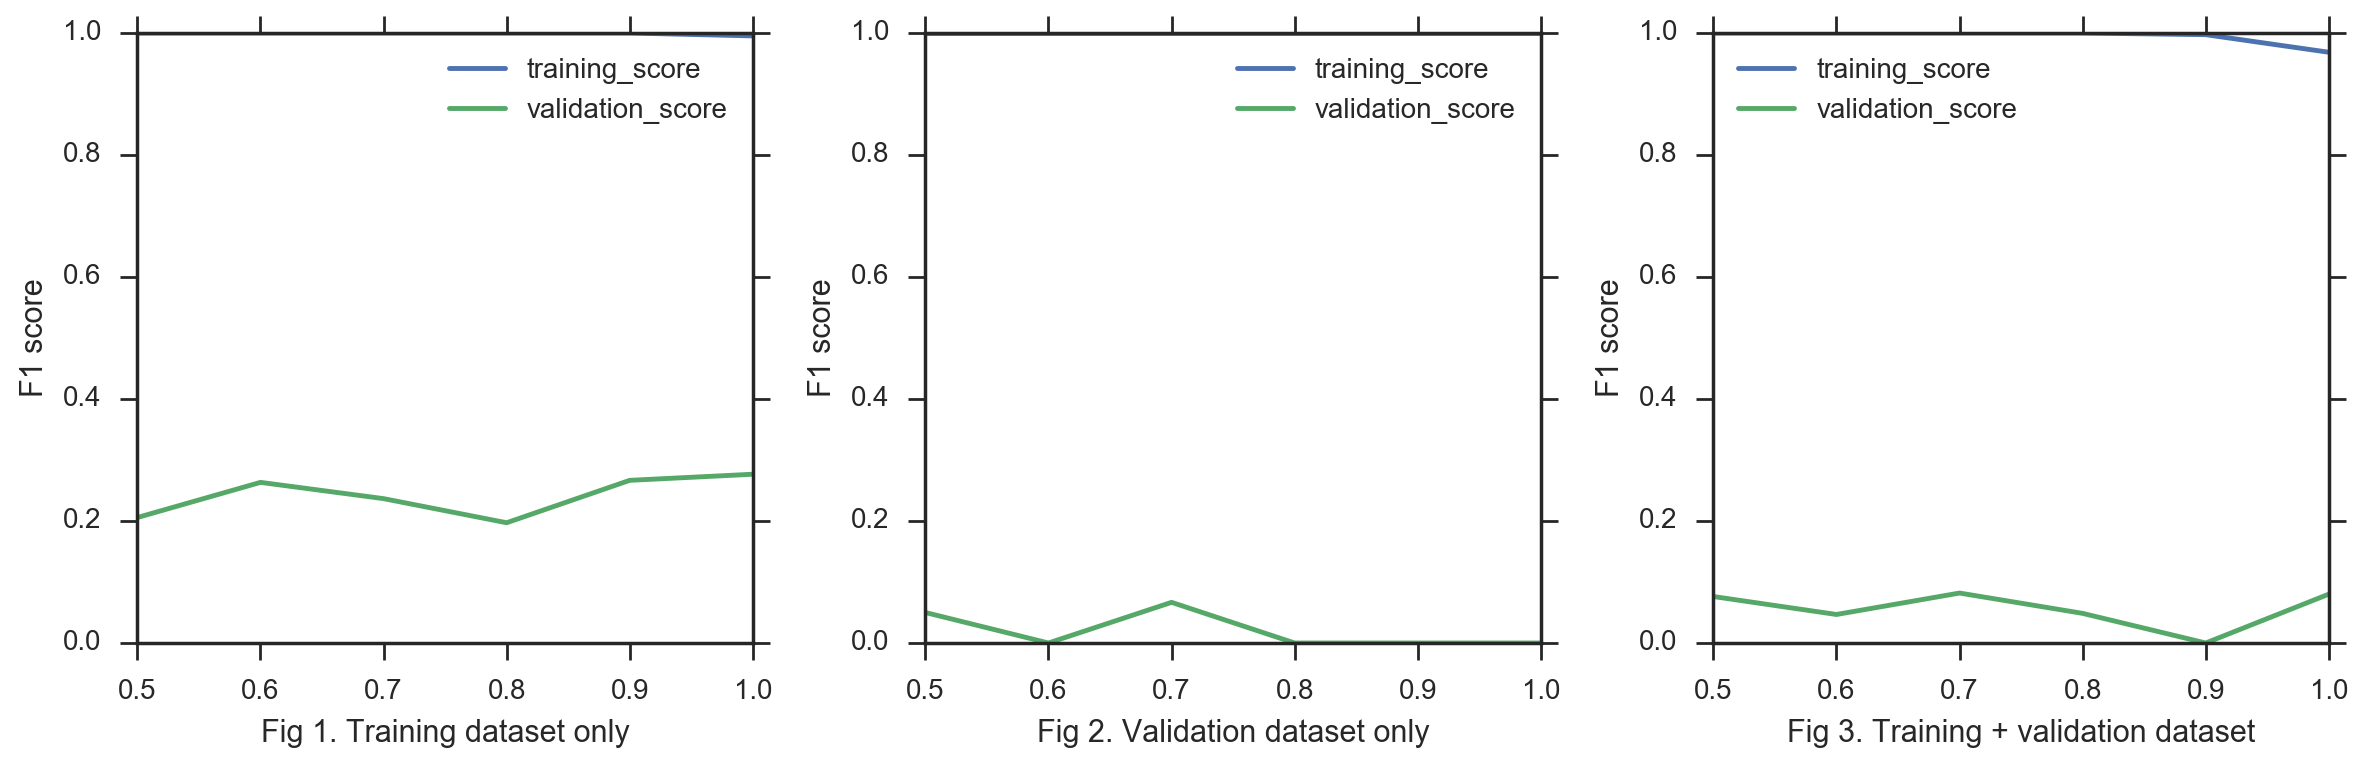

In [67]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
fig.set_tight_layout(True)

lc_tscores.plot(ax=axes[0])
axes[0].set_ylim([0, 1])
axes[0].set_xlabel('Fig 1. Training dataset only');
axes[0].set_ylabel('F1 score');

lc_vscores.plot(ax=axes[1])
axes[1].set_ylim([0, 1])
axes[1].set_xlabel('Fig 2. Validation dataset only');
axes[1].set_ylabel('F1 score');

lc_lscores.plot(ax=axes[2])
axes[2].set_ylim([0, 1])
axes[2].set_xlabel('Fig 3. Training + validation dataset');
axes[2].set_ylabel('F1 score');

## Model testing

In [68]:
unlabelled_path = testing_path = '../downloads/highway-classifier/unlabelled/'

In [69]:
unlabelled = pd.read_csv(unlabelled_path + 'attributes.csv')
unlabelled.head()

,changeset_id,changeset_harmful,feature_id,feature_version,action_create,action_modify,action_delete,geometry_type_node,geometry_type_way,geometry_type_relation,geometry_distance_between_versions,old_geometry_line_distance,old_geometry_number_of_nodes,old_geometry_kinks,old_geometry_area,new_geometry_line_distance,new_geometry_number_of_nodes,new_geometry_kinks,new_geometry_area,old_user_mapping_days,new_user_mapping_days,difference_user_mapping_days,ratio_user_mapping_days,old_number_of_tags,new_number_of_tags,difference_number_of_tags,ratio_number_of_tags,old_tags,new_tags
0,49180736,NaN,497516862,2,0,1,0,0,1,0,0.00,0.03,21,0,0.0,0.03,21,0,0.0,780,780,0,1.00e+00,1,4,3,4.00,NaN,{access=no} {foot=permissive} {surface=fine_gr...
1,49180683,NaN,30613789,4,0,1,0,0,1,0,0.00,0.04,10,0,0.0,0.04,10,0,0.0,662,1,-661,1.51e-03,3,4,1,1.33,NaN,{motor_vehicle=permissive}
2,49180628,NaN,103763048,11,0,1,0,0,1,0,0.00,4.88,88,0,0.0,4.88,88,0,0.0,150,150,0,1.00e+00,5,6,1,1.20,NaN,NaN
3,49180608,NaN,4482158804,2,0,1,0,1,0,0,0.13,0.00,2,0,0.0,0.00,2,0,0.0,11,11,0,1.00e+00,0,1,1,0.00,NaN,{highway=turning_circle}
4,49180580,NaN,374883613,2,0,1,0,0,1,0,0.00,0.04,6,0,0.0,0.04,6,0,0.0,621,245,-376,3.95e-01,1,2,1,2.00,NaN,{access=private}


In [70]:
# Drop all duplicate samples.
print('Shape before dropping duplicates: {}'.format(unlabelled.shape))
unlabelled = unlabelled.drop_duplicates(subset=['changeset_id', 'feature_id'])
print('Shape after dropping duplicates: {}'.format(unlabelled.shape))

Shape before dropping duplicates: (121, 29)
Shape after dropping duplicates: (121, 29)


In [71]:
# Fill null values in tags with empty string.
unlabelled['old_tags'] = unlabelled['old_tags'].fillna('')
unlabelled['new_tags'] = unlabelled['new_tags'].fillna('')

In [72]:
# Using all of the unlabelled dataset for testing.
testing = unlabelled.sample(unlabelled.shape[0])

In [73]:
# Vectorize old_tags.
old_vectorized = pd.DataFrame(old_vectorizer.transform(testing['old_tags']).toarray(), columns=old_vectorizer.get_feature_names())
old_vectorized.columns = ['old_{}'.format(item) for item in old_vectorized.columns]

# Vectorize new_tags.
new_vectorized = pd.DataFrame(new_vectorizer.transform(testing['new_tags']).toarray(), columns=new_vectorizer.get_feature_names())
new_vectorized.columns = ['new_{}'.format(item) for item in new_vectorized.columns]

In [74]:
# Concatenate both initial validation data and vectorized data.
testing = pd.concat([testing, new_vectorized, old_vectorized], axis=1)
print(testing.shape)
testing.head()

(121, 553)


,changeset_id,changeset_harmful,feature_id,feature_version,action_create,action_modify,action_delete,geometry_type_node,geometry_type_way,geometry_type_relation,geometry_distance_between_versions,old_geometry_line_distance,old_geometry_number_of_nodes,old_geometry_kinks,old_geometry_area,new_geometry_line_distance,new_geometry_number_of_nodes,new_geometry_kinks,new_geometry_area,old_user_mapping_days,new_user_mapping_days,difference_user_mapping_days,ratio_user_mapping_days,old_number_of_tags,new_number_of_tags,difference_number_of_tags,ratio_number_of_tags,old_tags,new_tags,new_access:conditional=yes @(08:00-20:00),new_access=destination,new_access=no,new_access=permissive,new_access=private,new_access=yes,new_access=yes|yes|no,new_access_control=yes,new_agricultural=yes,new_amenity=school,new_area=no,new_area=yes,new_barrier=gate,new_barrier=yes,new_bench=no,new_bench=yes,new_bicycle=designated,new_bicycle=discouraged,new_bicycle=dismount,new_bicycle=no,new_bicycle=permissive,new_bicycle=yes,new_bridge:name=Klaas Bordingbrug,new_bridge=boardwalk,new_bridge=yes,new_bus=yes,new_bus_routes=411A;416;417A;410,new_button_operated=no,new_car=no,new_construction=motorway,new_construction=no,new_construction=tertiary,new_construction=unclassified,new_construction=yes,new_crossing=no,new_crossing=traffic_signals,new_crossing=uncontrolled,new_crossing=zebra,new_crossing_ref=zebra,new_cycleway:left=lane,new_cycleway:left=opposite_lane,new_cycleway:left=track,new_cycleway:right=lane,new_cycleway:right=opposite,new_cycleway:right=opposite_lane,new_cycleway:right=shared_lane,new_cycleway=lane,new_cycleway=opposite,new_cycleway=opposite_lane,new_cycleway=share_busway,new_cycleway=shared_lane,new_cycleway=track,new_depth=60 m,new_designation=byway_open_to_all_traffic,new_destination:ref=A20,new_destination:ref=A249,new_destination:ref=I-10 East;I-10 West,new_destination:street=Enniskillen Road,new_destination:street=Market Street,new_destination=Camp Petersville,new_destination=Maidstone (E),new_destination=NJ 42,new_destination=OSTATNÍ TRANZIT;PRAHA - Centrum|TEPLICE;PRAHA - ČERNÝ MOST,new_destination=Sheerness;Maidstone,new_direction=both,new_direction=forward,new_embankment=yes,new_end_date=2017-03-07,new_enforcement=maxspeed,"new_fixme=en attente d'areté municipal (probablement bande cyc lable) si cela se transforme en piste, ontraçera les deux pistes monodirectionnelles",new_fixme=turn:lanes:forward - double check not visible from imagery,new_foot=designated,new_foot=no,new_foot=permissive,new_foot=private,new_foot=yes,new_footway=crossing,new_footway=sidewalk,new_handrail=yes,new_hgv=no,new_highway=bridleway,new_highway=bus_stop,new_highway=coastline,new_highway=construction,new_highway=crossing,new_highway=cycleway,new_highway=elevator,new_highway=footway,new_highway=living_street,new_highway=mini_roundabout,new_highway=motorway,new_highway=motorway_junction,new_highway=motorway_link,new_highway=path,new_highway=pedestrian,new_highway=primary,new_highway=primary_link,new_highway=raceway,new_highway=residential,new_highway=road,new_highway=secondary,new_highway=secondary_link,new_highway=service,new_highway=speed_camera,new_highway=steps,new_highway=stop,new_highway=tertiary,new_highway=tertiary_link,new_highway=track,new_highway=traffic_signals,new_highway=trunk,new_highway=turning_circle,new_highway=turning_loop,new_highway=unclassified,new_highway_1=footway,new_historic=construction,new_horse=no,new_horse=permissive,new_horse=yes,new_incline=up,new_internet_access=wlan,new_junction=roundabout,new_kerb=flush,new_landuse=cemetery,new_landuse=footway,new_landuse=forest,new_landuse=grass,new_landuse=recreation_ground,new_landuse=residential,new_landuse_1=park,new_landuse_1=recreation_ground,new_landuse_2=festival area,new_landuse_3=dog park,new_landuse_3=recreation,new_landuse_4=recreation_ground,new_landuse_5=water_park,new_lanes:forward=1,new_lanes:forward=3,new_lanes=1,new_lanes=2,new_lanes=3,new_lanes=4,new_lanes=5,new_layer=-1,new_

In [75]:
testing.describe()

,changeset_id,changeset_harmful,feature_id,feature_version,action_create,action_modify,action_delete,geometry_type_node,geometry_type_way,geometry_type_relation,geometry_distance_between_versions,old_geometry_line_distance,old_geometry_number_of_nodes,old_geometry_kinks,old_geometry_area,new_geometry_line_distance,new_geometry_number_of_nodes,new_geometry_kinks,new_geometry_area,old_user_mapping_days,new_user_mapping_days,difference_user_mapping_days,ratio_user_mapping_days,old_number_of_tags,new_number_of_tags,difference_number_of_tags,ratio_number_of_tags,new_access:conditional=yes @(08:00-20:00),new_access=destination,new_access=no,new_access=permissive,new_access=private,new_access=yes,new_access=yes|yes|no,new_access_control=yes,new_agricultural=yes,new_amenity=school,new_area=no,new_area=yes,new_barrier=gate,new_barrier=yes,new_bench=no,new_bench=yes,new_bicycle=designated,new_bicycle=discouraged,new_bicycle=dismount,new_bicycle=no,new_bicycle=permissive,new_bicycle=yes,new_bridge:name=Klaas Bordingbrug,new_bridge=boardwalk,new_bridge=yes,new_bus=yes,new_bus_routes=411A;416;417A;410,new_button_operated=no,new_car=no,new_construction=motorway,new_construction=no,new_construction=tertiary,new_construction=unclassified,new_construction=yes,new_crossing=no,new_crossing=traffic_signals,new_crossing=uncontrolled,new_crossing=zebra,new_crossing_ref=zebra,new_cycleway:left=lane,new_cycleway:left=opposite_lane,new_cycleway:left=track,new_cycleway:right=lane,new_cycleway:right=opposite,new_cycleway:right=opposite_lane,new_cycleway:right=shared_lane,new_cycleway=lane,new_cycleway=opposite,new_cycleway=opposite_lane,new_cycleway=share_busway,new_cycleway=shared_lane,new_cycleway=track,new_depth=60 m,new_designation=byway_open_to_all_traffic,new_destination:ref=A20,new_destination:ref=A249,new_destination:ref=I-10 East;I-10 West,new_destination:street=Enniskillen Road,new_destination:street=Market Street,new_destination=Camp Petersville,new_destination=Maidstone (E),new_destination=NJ 42,new_destination=OSTATNÍ TRANZIT;PRAHA - Centrum|TEPLICE;PRAHA - ČERNÝ MOST,new_destination=Sheerness;Maidstone,new_direction=both,new_direction=forward,new_embankment=yes,new_end_date=2017-03-07,new_enforcement=maxspeed,"new_fixme=en attente d'areté municipal (probablement bande cyc lable) si cela se transforme en piste, ontraçera les deux pistes monodirectionnelles",new_fixme=turn:lanes:forward - double check not visible from imagery,new_foot=designated,new_foot=no,new_foot=permissive,new_foot=private,new_foot=yes,new_footway=crossing,new_footway=sidewalk,new_handrail=yes,new_hgv=no,new_highway=bridleway,new_highway=bus_stop,new_highway=coastline,new_highway=construction,new_highway=crossing,new_highway=cycleway,new_highway=elevator,new_highway=footway,new_highway=living_street,new_highway=mini_roundabout,new_highway=motorway,new_highway=motorway_junction,new_highway=motorway_link,new_highway=path,new_highway=pedestrian,new_highway=primary,new_highway=primary_link,new_highway=raceway,new_highway=residential,new_highway=road,new_highway=secondary,new_highway=secondary_link,new_highway=service,new_highway=speed_camera,new_highway=steps,new_highway=stop,new_highway=tertiary,new_highway=tertiary_link,new_highway=track,new_highway=traffic_signals,new_highway=trunk,new_highway=turning_circle,new_highway=turning_loop,new_highway=unclassified,new_highway_1=footway,new_historic=construction,new_horse=no,new_horse=permissive,new_horse=yes,new_incline=up,new_internet_access=wlan,new_junction=roundabout,new_kerb=flush,new_landuse=cemetery,new_landuse=footway,new_landuse=forest,new_landuse=grass,new_landuse=recreation_ground,new_landuse=residential,new_landuse_1=park,new_landuse_1=recreation_ground,new_landuse_2=festival area,new_landuse_3=dog park,new_landuse_3=recreation,new_landuse_4=recreation_ground,new_landuse_5=water_park,new_lanes:forward=1,new_lanes:forward=3,new_lanes=1,new_lanes=2,new_lanes=3,new_lanes=4,new_lanes=5,new_layer=-1,new_layer=1,new_layer=

In [76]:
# Add good way to check if all properties are ok.
testing.sum()

changeset_id                                                                                            5950551552
changeset_harmful                                                                                             None
feature_id                                                                                             52478211533
feature_version                                                                                                502
action_create                                                                                                    4
action_modify                                                                                                  116
action_delete                                                                                                    1
geometry_type_node                                                                                               6
geometry_type_way                                                               

In [77]:
tX = testing.drop(non_training_attributes, axis=1)
ty = testing['changeset_harmful']

In [78]:
testing['prediction'] = model.predict(tX)
testing.to_csv(unlabelled_path + 'testing-review.csv', index=False)

In [79]:
tharmful_count = testing[testing['prediction'] == True].shape[0]
tnot_harmful_count = testing[testing['prediction'] == False].shape[0]

print('Predicted good: {}'.format(tnot_harmful_count))
print('Predicted harmful: {}'.format(tharmful_count))

print('Percentage harmful: {}%'.format(round(100.0 * tharmful_count / testing.shape[0], 2)))

Predicted good: 120
Predicted harmful: 1
Percentage harmful: 0.83%
